In [1]:
import json
import time

import numpy as np
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(0)

def classify_subcategory(text):
    likelihoods = [0 for _ in range(len(SUBCATEGORIES))]
    text = set(removePunctuation(text).lower().split())
    for token in text:
        if token in stop_words:
            continue

        if token in word_to_subcat:
            for i in range(len(SUBCATEGORIES)):
                likelihoods[i] += word_to_subcat[token][i]
        else:
            # print('Token not in word-to-subcat:', token)
            pass

    return SUBCATEGORIES[likelihoods.index(max(likelihoods))]


def hhi(arr):
    return sum([_**2 for _ in arr]) / sum(arr) ** 2


def normalized_hhi(arr):
    return (hhi(arr) - 1/len(arr)) / (1 - 1/len(arr))


def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)


with open('../stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('../subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

time_now = time.perf_counter()
with open('word-to-subcat-normalized.json') as f:
    word_to_subcat = json.load(f)
print('Time to load word-to-subcat-normalized:', time.perf_counter() - time_now, 'seconds')

for word in word_to_subcat:
    if normalized_hhi(word_to_subcat[word]) < 0.01:
        print(word)
    # factor = normalized_hhi(word_to_subcat[word])
    factor = normalized_hhi(
        word_to_subcat[word])**5 / sum(word_to_subcat[word])
    word_to_subcat[word] = [factor * i for i in word_to_subcat[word]]


print('=====Begin Testing=====')
time_now = time.perf_counter()

questions = open('questions.json')
questions = questions.readlines()
np.random.shuffle(questions)
questions = questions[:int(0.2*len(questions))]
counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))]
                    for _ in range(len(SUBCATEGORIES))]
for line in questions:
    data = json.loads(line)
    if 'subcategory' not in data:
        continue

    counter += 1
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES:
        continue

    if data['type'] == 'tossup':
        prediction = classify_subcategory(data['question'])
    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        prediction = classify_subcategory(
            data['leadin'] + ' ' + data['parts'][0] + data['parts'][1] + data['parts'][2])

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {correct / counter} ({correct}/{counter})')
print('Time:', time.perf_counter() - time_now, 'seconds')


Time to load word-to-subcat-normalized: 2.7690207039704546 seconds
=====Begin Testing=====
7173/10000
14353/20000
21548/30000
=====End Testing=====
Accuracy: 0.7182126598428393 (24769/34487)
Time: 11.652159490040503 seconds


In [2]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [1323, 80, 1, 68, 49, 10, 54, 2, 30, 18, 1, 17, 10, 7, 2, 12, 58, 57, 17, 14, 24, 24, 14, 5, 9, 2, 21]
British Literature   [53, 1196, 3, 50, 20, 4, 17, 3, 34, 8, 2, 12, 6, 3, 2, 6, 46, 25, 10, 15, 38, 18, 10, 4, 9, 5, 4]
Classical Literature [1, 4, 10, 3, 9, 2, 3, 5, 0, 3, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 20, 8, 1, 0, 1, 0, 0]
European Literature  [43, 43, 3, 909, 31, 4, 6, 2, 29, 7, 1, 8, 6, 8, 0, 2, 43, 57, 13, 13, 26, 19, 7, 1, 8, 1, 5]
World Literature     [48, 33, 3, 31, 697, 3, 13, 2, 15, 28, 2, 11, 4, 3, 2, 6, 28, 22, 4, 23, 36, 15, 6, 2, 2, 3, 3]
Other Literature     [56, 44, 2, 21, 32, 27, 3, 1, 1, 3, 0, 2, 1, 4, 0, 6, 7, 10, 4, 3, 14, 3, 3, 0, 0, 1, 5]
American History     [37, 26, 2, 8, 9, 2, 1474, 10, 77, 79, 3, 20, 13, 12, 0, 15, 35, 26, 11, 35, 14, 22, 32, 22, 22, 10, 19]
Ancient History      [5, 8, 0, 0, 3, 1, 7, 289, 59, 23, 7, 3, 3, 0, 1, 4, 14, 9, 3, 13, 32, 7, 1, 0, 4, 0, 0]
European History     [17, 27, 0, 22, 6, 2, 64, 49, 1798,

<AxesSubplot:>

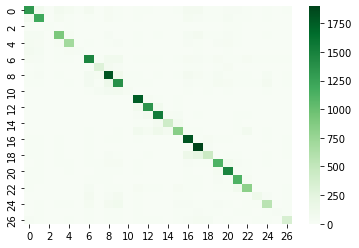

In [3]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

In [4]:
# ConfusionMatrixDisplay(np.array(confusion_matrix), display_labels='').plot()